In [1]:
!pip install gymnasium
!pip install -q swig
!pip install -q gymnasium[box2d]
import gymnasium as gym
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Problem 1: DDPG

#### (a)

In [2]:
env = gym.make('MountainCarContinuous-v0')
print("The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1]: ", env.action_space)
print("State space comprises of position of car along x axis and velocity of car  -> ", env.observation_space)

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)

    print(f'state: {state}')
    print(f'action: {action}')
    print(f'next state: {next_state}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        state, _ = env.reset()

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1]:  Box(-1.0, 1.0, (1,), float32)
State space comprises of position of car along x axis and velocity of car  ->  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

Random agent to understand reward and states: 

state: [-0.44348088  0.        ]
action: [0.2143983]
next state: [-4.4375437e-01 -2.7351803e-04]
reward: -0.004596662876480995

state: [-4.4375437e-01 -2.7351803e-04]
action: [0.05637455]
next state: [-0.44453645 -0.00078208]
reward: -0.0003178090292585992

state: [-0.44453645 -0.00078208]
action: [0.23444298]
next state: [-0.4455543  -0.00101784]
reward: -0.005496351044804815

state: [-0.4455543  -0.00101784]
action: [0.56375676]
next state: [-0.4463065 -0.0007522]
reward: -0.03178216888825638

state: [-0.4463065 -0.0007522]
action: [-0.66200316]
next state: [-0.44862622 -0.00231972]
reward: -0.043824818321844816



In [3]:
env = gym.make('LunarLanderContinuous-v2')
print("Action space: ", env.action_space)
print("State space comprises of coordinates of lander in x&y, velocities in x&y, angle, angular velocity, two booleans (whether each leg is in contact with the ground or not):  ", env.observation_space)

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)

    print(f'state: {state}')
    print(f'action: {action}')
    print(f'next state: {next_state}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        state, _ = env.reset()

Action space:  Box(-1.0, 1.0, (2,), float32)
State space comprises of coordinates of lander in x&y, velocities in x&y, angle, angular velocity, two booleans (whether each leg is in contact with the ground or not):   Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

Random agent to understand reward and states: 

state: [-0.00741301  1.4050467  -0.7508634  -0.26108095  0.00859651  0.17008169
  0.          0.        ]
action: [-0.37891182  0.02049788]
next state: [-0.01482639  1.3985966  -0.7498483  -0.28673527  0.01700083  0.16810331
  0.          0.        ]
reward: -0.9855896025786706

state: [-0.01482639  1.3985966  -0.7498483  -0.28673527  0.01700083  0.16810331
  0.          0.        ]
action: [0.22687241 0.5071774 ]
next state: [-0.02209396  1.3919615  -0.73450404 -0.29500082  0.02465897  0.15317729
  0.          0.        ]
reward: 0.815769421126054

#### (b)

In [4]:
# Define Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# Define Actor Network
class actor(nn.Module):
    def __init__(self, n_state, n_action):
        super(actor, self).__init__()
        self.layer1 = nn.Linear(n_state, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        return x

In [6]:
# Define Critic Network
class critic(nn.Module):

    def __init__(self, n_state, n_action):
        super(critic, self).__init__()
        self.layer1 = nn.Linear(n_state + n_action, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [15]:
# Define class for Gaussian Noise
class GaussianNoise:
    def __init__(self, mean=0, var=1):
        self.mean = mean
        self.var = var

    def generate(self):
        noise = torch.normal(self.mean, self.var)
        return noise

In [8]:
# Define class for OU Noise
class OUNoise:
    def __init__(self, size, mean=0, theta=0.15, var=0.2):
        self.size = size
        self.mean = mean
        self.theta = theta
        self.var = var
        self.state = torch.ones(self.size) * self.mean
        self.reset()

    def reset(self):
        self.state = torch.ones(self.size) * self.mean

    def generate(self):
        x = self.state
        dx = self.theta * (self.mean - x) + self.var * torch.randn(self.size)
        self.state = x + dx
        return self.state

In [22]:
# DDPG class
class DDPG():

    def __init__(self, env, replay_memory_size=10000, lra=1e-3, lrc=1e-3, batch_size=100, time_steps=200, tau=0.99, gamma=0.99, update_target=5, num_episodes=1000, Noise='Gaussian'):
        # Initialize DDPG with environment, hyperparameters, and neural networks
        self.env = env
        state, _ = self.env.reset()
        self.n_state = len(state)
        self.n_action = self.env.action_space.shape[0]

        # Initialize actor and critic networks
        self.actor_net = actor(self.n_state, self.n_action).to(device)
        self.critic_net = critic(self.n_state, self.n_action).to(device)

        # Initialize target networks with the same weights
        self.target_actor_net = actor(self.n_state, self.n_action).to(device)
        self.target_critic_net = critic(self.n_state, self.n_action).to(device)
        self.target_actor_net.load_state_dict(self.actor_net.state_dict())
        self.target_critic_net.load_state_dict(self.critic_net.state_dict())

        # Initialize replay memory and optimizers
        self.replay_memory = ReplayMemory(replay_memory_size)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=lra)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=lrc)

        self.batch_size = batch_size
        self.time_steps = time_steps
        self.tau = tau
        self.gamma = gamma
        self.update_target = update_target

        if Noise=="OU":
            self.noise_generator = OUNoise(self.n_action)
        else:
            self.noise_generator = GaussianNoise(torch.zeros(self.n_action), torch.ones(self.n_action))

        if torch.cuda.is_available():
            self.num_episodes = num_episodes
        else:
            self.num_episodes = min(1000, num_episodes)

    def select_action(self, state, using_target_net=False):
        # Select an action based on the current state using the actor network

        noise = self.noise_generator.generate()
        noise = torch.tensor(noise, dtype=torch.float32)

        with torch.no_grad():
            if using_target_net:
                self.target_actor_net.eval()
                action = self.target_actor_net(state) + noise
            else:
                self.actor_net.eval()
                action = self.actor_net(state) + noise
                self.actor_net.train()

        action = torch.clamp(action, min=-1, max=1)

        return action

    def optimize(self):
        # Perform a single optimization step for the actor and critic networks
        batch = self.replay_memory.sample(self.batch_size)
        batch = Transition(*zip(*batch))

        self.actor_net.train()
        self.critic_net.train()

        state_batch = torch.cat(batch.state, dim=0).reshape(self.batch_size, self.n_state)
        action_batch = torch.cat(batch.action, dim=0).reshape(self.batch_size, self.n_action)
        reward_batch = torch.tensor(batch.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).reshape([-1,self.n_state])

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_actions = self.select_action(non_final_next_states, using_target_net=True)
            next_state_values[non_final_mask] = self.target_critic_net(non_final_next_states, next_actions)[:,0]

        target_state_action_values = reward_batch + self.gamma * next_state_values
        target_state_action_values = target_state_action_values.type('torch.FloatTensor')
        state_action_values = self.critic_net(state_batch, action_batch)[:, 0]

        criterion = torch.nn.MSELoss()
        critic_loss = criterion(state_action_values, target_state_action_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_value_(self.critic_net.parameters(), 100)
        self.critic_optimizer.step()

        actions = self.select_action(state_batch)
        state_action_values = self.critic_net(state_batch, actions)
        actor_loss = -1 * torch.mean(actions * state_action_values)

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return

    def train(self):
        # Train the DDPG agent for a specified number of episodes
        step = 0
        state, _ = env.reset()
        avg_rewards = []
        best_rewards = []

        # Initialize replay memory with random actions
        for i in range(self.batch_size):
            state = self.env.observation_space.sample()
            state = torch.tensor(state, dtype=torch.float32, device=device)
            action = self.select_action(state)
            next_state, reward, terminated, trucated, _ = self.env.step(torch.Tensor.numpy(action))
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            self.replay_memory.push(state, action, next_state, reward)

        # Main training loop
        for episode in range(self.num_episodes):
            state, _ = env.reset()
            tot_reward = 0
            for t in range(self.time_steps):
                state = torch.tensor(state, dtype=torch.float32, device=device)
                action = self.select_action(state)
                next_state, reward, terminated, trucated, _ = self.env.step(torch.Tensor.numpy(action))

                tot_reward += reward
                step += 1

                if terminated or trucated:
                    next_state = None
                else:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)

                self.replay_memory.push(state, action, next_state, reward)

                state = next_state

                self.optimize()

                if step % self.update_target == 0:
                    self.target_actor_net.load_state_dict(self.actor_net.state_dict())
                    self.target_critic_net.load_state_dict(self.critic_net.state_dict())

                if terminated or trucated:
                    break

            # Evaluate the agent's performance every 10 episodes
            if episode % 10 == 0:
                print(f'episode: {episode}')
                test_rewards = []
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32, device=device)

                for i in range(10):
                    r = 0.0
                    while True:
                        action = self.select_action(state)
                        next_state, reward, terminated, trucated, _ = self.env.step(torch.Tensor.numpy(action))
                        r += reward
                        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                        state = next_state
                        if terminated or trucated:
                            break
                    test_rewards.append(r)
                test_rewards = torch.tensor(test_rewards, dtype=torch.float32)
                avg_rewards.append(test_rewards.mean().item())
                best_rewards.append(test_rewards.max().item())
        return avg_rewards, best_rewards


In [19]:
env = gym.make('MountainCarContinuous-v0')
model = DDPG(env)
avg_rewards, best_rewards = model.train()

<ipython-input-18-e33a43611f05>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise = torch.tensor(noise, dtype=torch.float32)
<ipython-input-18-e33a43611f05>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

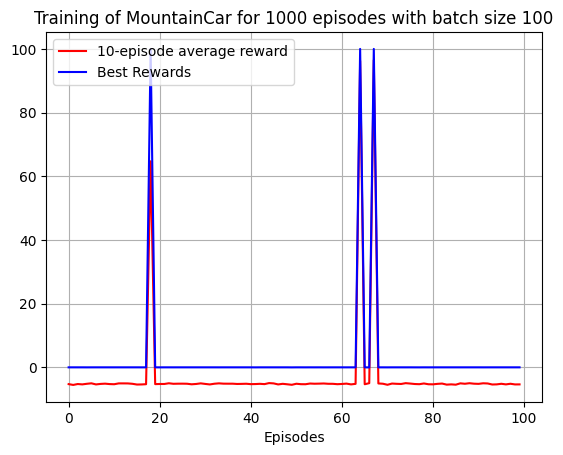

In [20]:
plt.plot(avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(best_rewards , 'b-' , label = "Best Rewards")
plt.title(f"Training of MountainCar for {model.num_episodes} episodes with batch size {model.batch_size}")
plt.grid(True)
plt.legend()
plt.xlabel("Episodes")
plt.show()

In [23]:
env = gym.make('LunarLanderContinuous-v2')
model = DDPG(env)
avg_rewards, best_rewards = model.train()

<ipython-input-22-c5f9f3fed5c3>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise = torch.tensor(noise, dtype=torch.float32)
<ipython-input-22-c5f9f3fed5c3>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

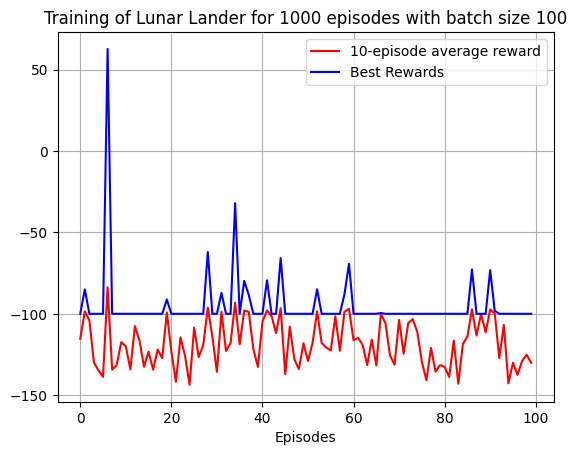

In [24]:
plt.plot( avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot( best_rewards , 'b-' , label = "Best Rewards")
plt.title(f"Training of Lunar Lander for {model.num_episodes} episodes with batch size {model.batch_size}")
plt.grid(True)
plt.legend()
plt.xlabel("Episodes")
plt.show()

#### (c)

<ipython-input-9-e882d7bb555e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise = torch.tensor(noise, dtype=torch.float32)
<ipython-input-9-e882d7bb555e>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_state_action_values = torch.tensor(reward_batch + self.gamma * next_state_values, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
<ipython-input-9-e882d7bb555

episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

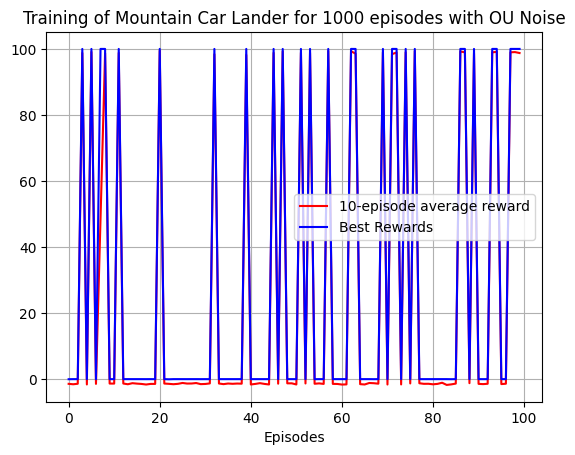

In [10]:
env = gym.make('MountainCarContinuous-v0')
model = DDPG(env, Noise="OU")
avg_rewards, best_rewards = model.train()

plt.plot(avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(best_rewards , 'b-' , label = "Best Rewards")
plt.title(f"Training of Mountain Car Lander for {model.num_episodes} episodes with OU Noise")
plt.grid(True)
plt.legend()
plt.xlabel("Episodes")
plt.show()

<ipython-input-9-e882d7bb555e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise = torch.tensor(noise, dtype=torch.float32)
<ipython-input-9-e882d7bb555e>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_state_action_values = torch.tensor(reward_batch + self.gamma * next_state_values, dtype=torch.float32)
<ipython-input-9-e882d7bb555e>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

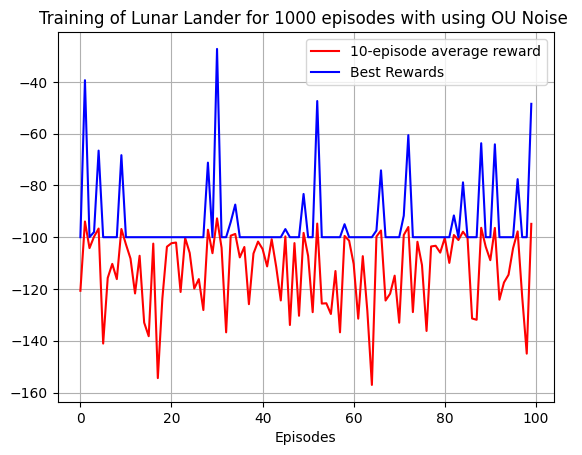

In [11]:
env = gym.make('LunarLanderContinuous-v2')
model = DDPG(env, Noise="OU")
avg_rewards, best_rewards = model.train()

plt.plot(avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(best_rewards , 'b-' , label = "Best Rewards")
plt.title(f"Training of Lunar Lander for {model.num_episodes} episodes with using OU Noise ")
plt.grid(True)
plt.legend()
plt.xlabel("Episodes")
plt.show()

Here we can see that rewards are more smooth for OU noise than Gausian. OU noise is correlated noise that helps in exploration by adding temporally correlated perturbations to the action space. This is beneficial in continuous action spaces as it promotes smoother exploration. Gaussian noise for exploration involves adding independent and identically distributed (i.i.d.) noise to the actions at each time step. Gaussian noise is uncorrelated and lacks the temporal structure present in OU noise.